# Model framework

**Example (state: 6 June 2017)**

    avg = AverageModel()  # create model
    avg.predict()  # predict one time step into the future, return as pandas dataframe
    avg.predict_all()  # make predictions for all original time points, return as pandas dataframe
    avg.score()  # call predict_all() and return the mean squared error between the predictions an
    



In [1]:
# TODO: Dirty hack to import from sibling dir. Put wahlrecht_polling_firms.py into the same folder as this file eventually.
import sys
import os
sys.path.append(os.path.abspath('../Backend'))
import wahlrecht_polling_firms

import numpy as np
import pandas as pd

## Data & Helper functions

In [2]:
parties = ['CDU/CSU', 'SPD', 'GRÜNE', 'FDP', 'LINKE', 'AfD', 'Sonstige']

In [3]:
# TODO: Maybe rename to complete_data_dict or full_data_dict to distinguish it from keyword args.
data_dict = wahlrecht_polling_firms.get_tables()

def _preprocess_df(df):
    df = df.fillna(0)  # TODO: Some values are NaN --> how to handle these? Especially, the numbers have to add up to 1.
    df['Befragte'] = df['Befragte'].apply(lambda x: int(x.replace('.', '').replace('NaN', '0')))  # TODO: Befragte column is string so far. Sometimes, there are also NaN values --> how to handle these? Should the polls be ignored for weighting or should an "average" value be used?
    #df[parties] /= 100  # TODO: Have values as 37 or 0.37?
    return df
    
data_dict = {key: _preprocess_df(df) for key, df in data_dict.items()}

In [4]:
def _normalize_to_hundred(x):
    """Normalize an array so that its sum is 1."""
    return 100 * x / np.sum(x)

np.sum(_normalize_to_hundred(np.linspace(0, 10)))

100.00000000000001

In [5]:
def _prediction_to_dataframe(prediction):
    """Wrap an array with the predictions into a dataframe containing the party names."""
    return pd.DataFrame(data=[prediction], columns=parties)

_prediction_to_dataframe(range(len(parties)))

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,0,1,2,3,4,5,6


In [6]:
def mse(poll_df, prediction_df):
    """Calculate the mean squared error between the polling results in `poll_df` and the predictions in `prediction_df`. Average over all parties."""
    # TODO: Have data_dict as parameter here? Or hand over data_dict['allensbach'] directly?
    # TODO: Refactor this once the model is wrapped in a class.
    mse = 0
    for party in parties:
        true_results = poll_df[party]
        predicted_results = prediction_df[party][1:1+len(true_results)]  # first point is prediction into the future, do not use it
        mse += np.mean((true_results - predicted_results)**2)        
    return mse / len(parties)

## Models

In [7]:
class Model():
    
    def fit(self, data_dict=data_dict):
        """Optional fit step to call before predictions. Leave empty if the model does not support fitting."""
        return
    
    def predict(self, data_dict=data_dict):
        raise NotImplementedError()
    
    def predict_all(self, data_dict=data_dict):
        """Make a prediction for each time point in the data."""
        num_timesteps = max([len(df) for df in data_dict.values()])  # take the max from all dataframes
        #print('Applying model to {} time points...'.format(num_timesteps))

        # First prediction, append the other ones below.
        prediction_df = self.predict(data_dict)

        for i in range(1, num_timesteps):
            sliced_data_dict = {key: df[i:] for key, df in data_dict.items()}
            # TODO: Maybe speed up models, especially the decay models. 
            # Note: Appending the data frames takes up almost no time here, the bottleneck is the model.
            # TODO: Due to ill-formated data, the resulting dataframe contains NaNs sometimes.
            prediction_df = prediction_df.append(self.predict(sliced_data_dict), ignore_index=True)
        
        return prediction_df
    
    def score(self, data_dict=data_dict, polling_firm=None):
        """Calculate a score for the model (lower is better). The score is the mean squared error between the model's predictions and the true results.
        If `polling_firm` is None (default), return a dict with the score for each polling firm. Otherwise, return only the score for that polling firm."""
        prediction_df = self.predict_all(data_dict)
    
        if polling_firm is None:
            return {polling_firm: mse(poll_df, prediction_df) for polling_firm, poll_df in data_dict.items()}
        else: 
            return mse(data_dict[polling_firm], prediction_df)

In [8]:
def average(data_dict=data_dict, n_last=5):
    """Average the last `n_last` polls from all polling firms."""
    prediction = np.zeros(len(parties))
    for df in data_dict.values():
        for i in range(min(n_last, len(df))):  # do not use more rows than the dataframe has
            results = df[parties].iloc[i]
            # TODO: Polls from different polling firms have different time spacing. Take this into account. 
            prediction += results
    return _prediction_to_dataframe(_normalize_to_hundred(prediction))

average(data_dict)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,35.685714,27.942857,7.6,7.0,8.514286,9.028571,4.228571


In [9]:
class AverageModel(Model):
    """Average the last `n_last` polls from all polling firms."""
    
    def __init__(self, n_last=5):
        self.n_last = n_last
        
    def predict(self, data_dict=data_dict):
        prediction = np.zeros(len(parties))
        for df in data_dict.values():
            for i in range(min(self.n_last, len(df))):  # do not use more rows than the dataframe has
                results = df[parties].iloc[i]
                # TODO: Polls from different polling firms have different time spacing. Take this into account. 
                prediction += results
        return _prediction_to_dataframe(_normalize_to_hundred(prediction))
    
AverageModel().predict(data_dict)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,35.685714,27.942857,7.6,7.0,8.514286,9.028571,4.228571


In [10]:
def weighted_average(data_dict=data_dict, n_last=5):
    """Average the last `n_last` polls from all polling firms, weighted by the number of participants."""
    prediction = np.zeros(len(parties))
    for df in data_dict.values():
        for i in range(min(n_last, len(df))):
            results = df[parties].iloc[i]
            num_people = df['Befragte'].iloc[i]#np.nan_to_num(float(df['Befragte'].iloc[i].replace('.', '').replace('T • ', '').replace('O • ', '')))
            # TODO: Polls from different polling firms have different time spacing. Take this into account. 
            prediction += results * num_people
    return _prediction_to_dataframe(_normalize_to_hundred(prediction))

weighted_average(data_dict)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,35.923507,27.797686,7.429243,7.11895,8.596604,8.808683,4.325328


In [11]:
class WeightedAverageModel(Model):
    """Average the last `n_last` polls from all polling firms, weighted by the number of participants."""
    
    # TODO: Maybe let this inherit from AverageModel to save __init__ function.
    def __init__(self, n_last=5):
        self.n_last = n_last
        
    def predict(self, data_dict=data_dict):
        prediction = np.zeros(len(parties))
        for df in data_dict.values():
            for i in range(min(self.n_last, len(df))):
                results = df[parties].iloc[i]
                num_people = df['Befragte'].iloc[i]#np.nan_to_num(float(df['Befragte'].iloc[i].replace('.', '').replace('T • ', '').replace('O • ', '')))
                # TODO: Polls from different polling firms have different time spacing. Take this into account. 
                prediction += results * num_people
        return _prediction_to_dataframe(_normalize_to_hundred(prediction))
    
WeightedAverageModel().predict(data_dict)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,35.923507,27.797686,7.429243,7.11895,8.596604,8.808683,4.325328


In [12]:
def latest(data_dict=data_dict):
    """Average the latest polls from all polling firms."""
    return average(data_dict, n_last=1)

latest(data_dict)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,37.357143,26.285714,7.285714,8.571429,8.142857,8.142857,4.214286


In [13]:
class LatestModel(AverageModel):
    """Average the latest polls from all polling firms."""
    
    def __init__(self):
        AverageModel.__init__(self, n_last=1)
    
LatestModel().predict(data_dict)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,37.357143,26.285714,7.285714,8.571429,8.142857,8.142857,4.214286


In [14]:
def weighted_latest(data_dict=data_dict):
    """Average the latest polls from all polling firms, weighted by the number of participants."""
    return weighted_average(data_dict, n_last=1)

weighted_latest(data_dict)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,37.449865,26.013628,7.191697,8.729061,8.308303,8.020578,4.286868


In [15]:
class WeightedLatestModel(WeightedAverageModel):
    """Average the latest polls from all polling firms."""
    
    def __init__(self):
        WeightedAverageModel.__init__(self, n_last=1)
    
WeightedLatestModel().predict(data_dict)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,37.449865,26.013628,7.191697,8.729061,8.308303,8.020578,4.286868


In [16]:
def decay(data_dict=data_dict, decay_factor=0.9):
    """Average all polls from all polling firms, where polls further back are weighted less (exponential decay)."""
    prediction = np.zeros(len(parties))
    for df in data_dict.values():
        for i in range(len(df)):
            results = df[parties].iloc[i]
            # TODO: Polls from different polling firms have different time spacing. Take this into account. 
            prediction += results * decay_factor**(i+1)
    return _prediction_to_dataframe(_normalize_to_hundred(prediction))

decay(data_dict)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,35.264821,26.578401,8.729182,6.402642,8.715661,9.819133,4.49016


In [17]:
class DecayModel(Model):
    """Average all polls from all polling firms, where polls further back are weighted less (exponential decay)."""
    
    def __init__(self, decay_factor=0.9):
        self.decay_factor = decay_factor
    
    def fit(self):
        # TODO: Fit decay_factor to get best results.
        pass
        
    def predict(self, data_dict=data_dict):
        prediction = np.zeros(len(parties))
        for df in data_dict.values():
            for i in range(len(df)):
                results = df[parties].iloc[i]
                # TODO: Polls from different polling firms have different time spacing. Take this into account. 
                prediction += results * self.decay_factor**(i+1)
        return _prediction_to_dataframe(_normalize_to_hundred(prediction))
    
DecayModel().predict(data_dict)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,35.264821,26.578401,8.729182,6.402642,8.715661,9.819133,4.49016


In [18]:
def weighted_decay(data_dict=data_dict, decay_factor=0.9):
    """Average all polls from all polling firms, where polls further back are weighted less (exponential decay) and each poll is weighted by the number of participants."""
    prediction = np.zeros(len(parties))
    for df in data_dict.values():
        for i in range(len(df)):
            results = df[parties].iloc[i]
            num_people = df['Befragte'].iloc[i]#np.nan_to_num(float(df['Befragte'].iloc[i].replace('.', '').replace('T • ', '').replace('O • ', '')))
            # TODO: Polls from different polling firms have different time spacing. Take this into account. 
            prediction += results * decay_factor**(i+1) * num_people
    return _prediction_to_dataframe(_normalize_to_hundred(prediction))

weighted_decay(data_dict)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,35.168653,26.897341,8.432378,6.479089,8.741683,9.721047,4.559809


In [19]:
class WeightedDecayModel(Model):
    """Average all polls from all polling firms, where polls further back are weighted less (exponential decay) and each poll is weighted by the number of participants."""
    
    # TODO: Maybe let this inherit from DecayModel to save __init__ function.
    def __init__(self, decay_factor=0.9):
        self.decay_factor = decay_factor
    
    def fit(self, data_dict=data_dict):
        # TODO: Fit decay_factor to get best results.
        pass
        
    def predict(self, data_dict=data_dict):
        prediction = np.zeros(len(parties))
        for df in data_dict.values():
            for i in range(len(df)):
                results = df[parties].iloc[i]
                num_people = df['Befragte'].iloc[i]#np.nan_to_num(float(df['Befragte'].iloc[i].replace('.', '').replace('T • ', '').replace('O • ', '')))
                # TODO: Polls from different polling firms have different time spacing. Take this into account. 
                prediction += results * self.decay_factor**(i+1) * num_people
        return _prediction_to_dataframe(_normalize_to_hundred(prediction))
    
WeightedDecayModel().predict(data_dict)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,35.168653,26.897341,8.432378,6.479089,8.741683,9.721047,4.559809


In [ ]:
class LinearRegressionModel(Model):
    
    def fit(self, data_dict=data_dict):
        pass
    
    def predict(self, data_dict=data_dict):
        pass

In [250]:
def apply_model(data_dict=data_dict, model=average, **kwargs):
    """Make a prediction using `model` for each time point in the data."""
    num_timesteps = max([len(df) for df in data_dict.values()])  # take the max from all dataframes
    #print('Applying model to {} time points...'.format(num_timesteps))
    
    prediction_df = model(data_dict, **kwargs)
    
    for i in range(1, num_timesteps):
        sliced_data_dict = {key: df[i:] for key, df in data_dict.items()}
        # TODO: Maybe speed up models, especially the decay models. 
        # Note: Appending the data frames takes up almost no time here, the bottleneck is the model.
        # TODO: Due to ill-formated data, the resulting dataframe contains NaNs sometimes.
        prediction_df = prediction_df.append(model(sliced_data_dict, **kwargs), ignore_index=True)
        
    return prediction_df
    
#pd.options.display.max_rows = 300
#apply_model(data_dict, average)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,35.685714,27.942857,7.600000,7.000000,8.514286,9.028571,4.228571
1,35.171429,28.085714,7.757143,6.542857,8.742857,9.471429,4.228571
2,34.671429,27.928571,8.014286,6.385714,8.714286,9.971429,4.314286
3,34.528571,27.371429,8.357143,6.314286,8.785714,10.271429,4.371429
4,34.285714,27.085714,8.628571,6.271429,8.728571,10.500000,4.500000
5,34.242857,26.728571,8.900000,6.171429,8.685714,10.657143,4.614286
6,34.071429,26.571429,9.157143,6.128571,8.542857,10.814286,4.714286
7,34.000000,26.414286,9.314286,6.042857,8.614286,10.857143,4.757143
8,33.800000,26.328571,9.471429,6.114286,8.557143,10.971429,4.757143
9,33.842857,26.285714,9.528571,6.128571,8.614286,10.828571,4.771429


In [154]:
def score_predictions(data_dict, prediction_df, polling_firm='allensbach'):
    """Calculate the mean squared error for the predictions in `prediction_df` vs the polling results from `polling_firm`. Average over all parties."""
    # TODO: Have data_dict as parameter here? Or hand over data_dict['allensbach'] directly?
    # TODO: Refactor this once the model is wrapped in a class.
    mse = 0
    for party in parties:
        true_results = data_dict[polling_firm][party]
        predicted_results = prediction_df[party][1:1+len(true_results)]  # first point is prediction for the future, do not use it
        mse += np.mean((true_results - predicted_results)**2)        
    return mse / len(parties)

In [155]:
def score_model(data_dict, model, polling_firm=None, **kwargs):
    """Calculate the mean squared error for the predictions from `model` vs the polling results from `polling_firm`. Average over all parties."""
    # TODO: Refactor this once the model is wrapped in a class.
    prediction_df = apply_model(data_dict, model, **kwargs)
    
    if polling_firm is None:
        return {polling_firm: score_predictions(data_dict, prediction_df, polling_firm=polling_firm) for polling_firm in data_dict}
    else: 
        return score_predictions(data_dict, prediction_df, polling_firm=polling_firm)
        

#score_model(data_dict, average)

{'allensbach': 4.394235177262506,
 'dimap': 3.9538424139821906,
 'emnid': 1.999201803215359,
 'forsa': 1.8950811763923394,
 'gms': 11.637584190100267,
 'insa': 3.5940972981997774,
 'politbarometer': 5.130305773796457}

# Quick and dirty evaluation

In [20]:
AverageModel().predict_all(data_dict)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,35.685714,27.942857,7.600000,7.000000,8.514286,9.028571,4.228571
1,35.171429,28.085714,7.757143,6.542857,8.742857,9.471429,4.228571
2,34.671429,27.928571,8.014286,6.385714,8.714286,9.971429,4.314286
3,34.528571,27.371429,8.357143,6.314286,8.785714,10.271429,4.371429
4,34.285714,27.085714,8.628571,6.271429,8.728571,10.500000,4.500000
5,34.242857,26.728571,8.900000,6.171429,8.685714,10.657143,4.614286
6,34.071429,26.571429,9.157143,6.128571,8.542857,10.814286,4.714286
7,34.000000,26.414286,9.314286,6.042857,8.614286,10.857143,4.757143
8,33.800000,26.328571,9.471429,6.114286,8.557143,10.971429,4.757143
9,33.842857,26.285714,9.528571,6.128571,8.614286,10.828571,4.771429


In [23]:
AverageModel().score(data_dict)

{'allensbach': 4.394235177262506,
 'dimap': 3.9538424139821906,
 'emnid': 1.999201803215359,
 'forsa': 1.8950811763923394,
 'gms': 11.637584190100267,
 'insa': 3.5940972981997774,
 'politbarometer': 5.130305773796457}

In [24]:
models = [AverageModel, WeightedAverageModel, LatestModel, WeightedLatestModel, DecayModel, WeightedDecayModel]

In [25]:
# MSE for all models.

# TODO: Maybe show a pandas table or a pcolor plot instead of the tabulate table here.
mse_df = pd.DataFrame(columns=data_dict.keys(), index=[model.__name__ for model in models])
for model in models:
    print('Running model: {}'.format(model.__name__))
    mse_dict = model().score(data_dict)
    mse_df.loc[model.__name__] = pd.Series(mse_dict)
    #result_table.append([model.__name__, *mses.values()])

print()
print('MSE between predicted results from model (vertical) and polls (horizontal):')

mse_df

Running model: AverageModel
Running model: WeightedAverageModel
Running model: LatestModel
Running model: WeightedLatestModel
Running model: DecayModel
Running model: WeightedDecayModel

MSE between predicted results from model (vertical) and polls (horizontal):


,allensbach,emnid,forsa,politbarometer,gms,dimap,insa
AverageModel,4.39424,1.9992,1.89508,5.13031,11.6376,3.95384,3.5941
WeightedAverageModel,6.7288,1.22622,1.26525,7.58613,15.1602,4.81996,2.67714
LatestModel,4.58096,1.76355,1.5239,5.12015,11.7845,3.97941,3.23137
WeightedLatestModel,7.05105,0.978359,0.872095,7.81436,15.4589,5.21948,2.31105
DecayModel,3.97555,2.53056,2.41619,4.70169,11.5139,3.79322,4.14285
WeightedDecayModel,5.99084,1.86884,1.88422,6.29939,14.4698,3.95591,3.32519


In [26]:
prediction_data_dict = {model.__name__: model().predict_all(data_dict) for model in models}

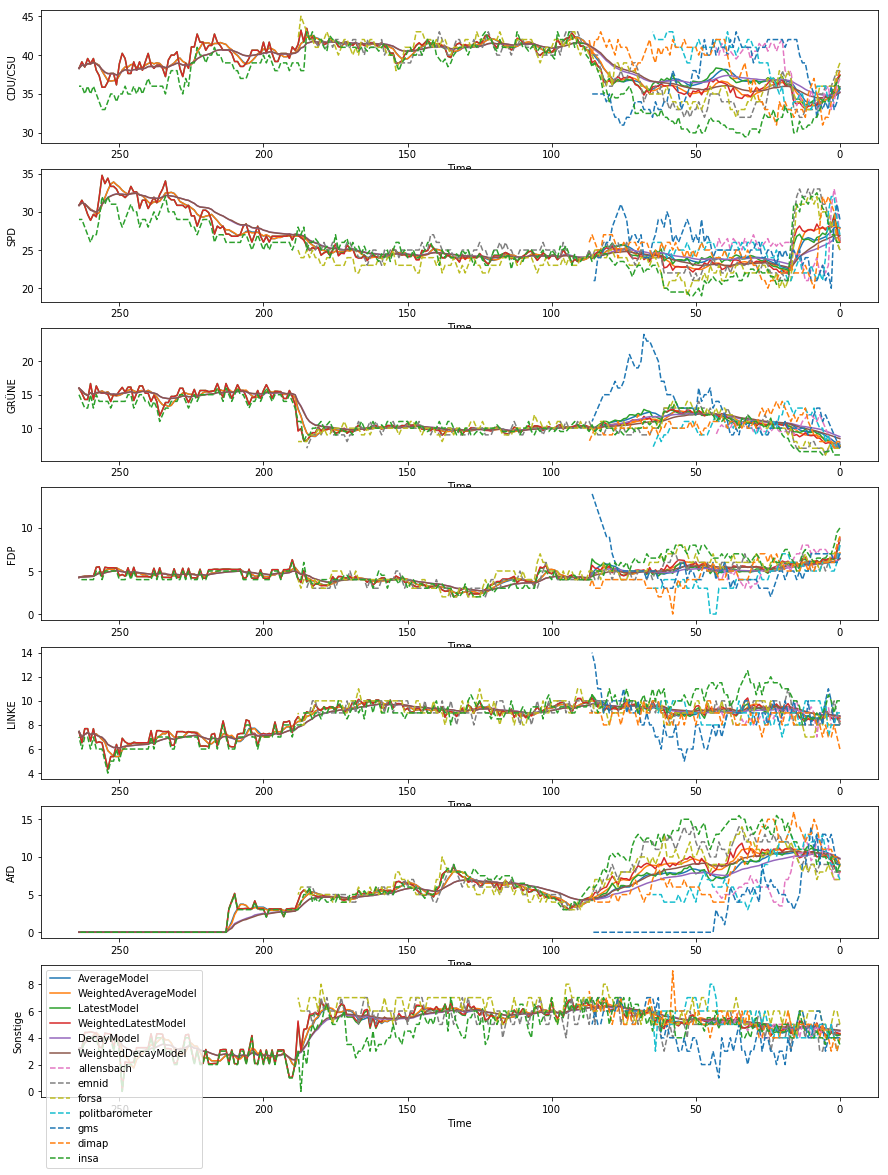

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(len(parties), figsize=(15, 20))

for ax, party in zip(axes, parties):
    plt.sca(ax)

    for model, df in prediction_data_dict.items():
        plt.plot(df[party], label=model)

    for polling_institute, df in data_dict.items():
        plt.plot(df[party], '--', label=polling_institute)

    #plt.legend()
    plt.gca().invert_xaxis()  # TODO: Time is inverted in data frames. Handle that somehow.
    plt.ylabel(party)
    plt.xlabel('Time')
    
plt.legend()